In [45]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [46]:
def read_file(file_name):
    file = open(file_name, "r")
    list_string = []
    i = 0
    while True:
        line = file.readline()
        list_string.append(line)
        if not line:
            break
        file.close
    return list_string

In [47]:
file_name = "Sim4ML3.dat"
main_data = []
list_string = read_file(file_name)
# last string is empty
list_string.pop()

''

In [48]:
# Parse data
param_data = []
signal_data = []
for string in list_string:
    data = np.fromstring(string, dtype=float, sep=' ')
    # Removing the row index at the beggining as it's redundant
    data = np.delete(data, 0)
    
    resistance_depth = data[:7]
    param_data.append(resistance_depth)

    signal_values = data[7:57]
    signal_data.append(signal_values)

In [49]:
len(signal_data)

535815

In [50]:
#Direct problem: by params predict signals

# Scale data
scaler = StandardScaler().fit(param_data)
param_data_scaled = scaler.transform(param_data)

# Split data to train and test
params_train, params_test, signal_train, signal_test = train_test_split(param_data_scaled, signal_data, 
                                                    train_size=0.67, 
                                                    random_state=42)

regr = linear_model.LinearRegression()

# Fit model
regr.fit(params_train, signal_train)

LinearRegression()

In [51]:
signal_pred = regr.predict(params_test)
print("Mean squared error: %.25f" % mean_squared_error(signal_test[0], signal_pred[0]))
print("Coefficient of determination: %.2f" % r2_score(signal_test, signal_pred))

Mean squared error: 0.0022908280004864754048066
Coefficient of determination: 0.49


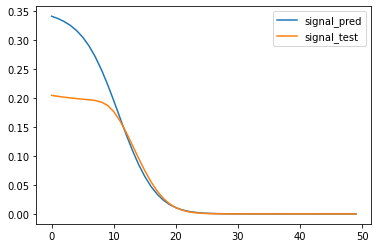

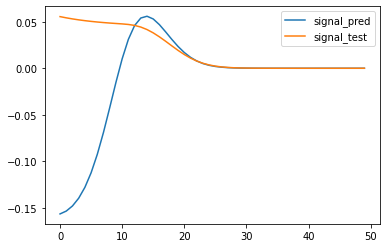

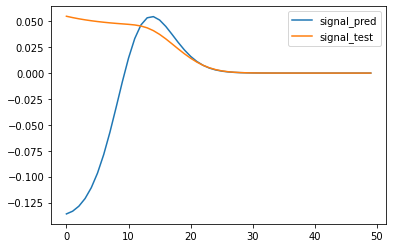

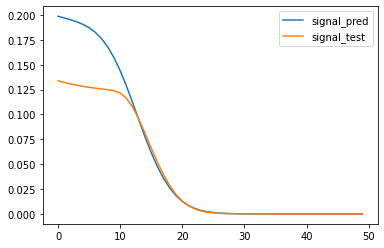

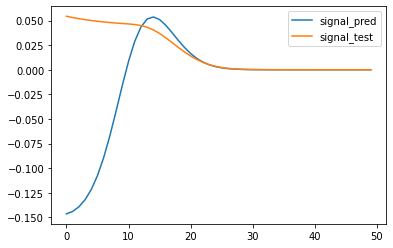

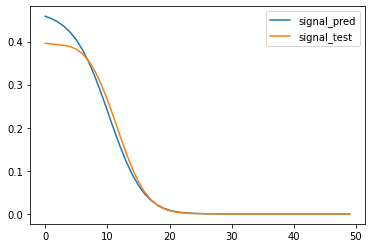

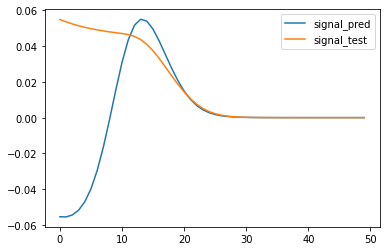

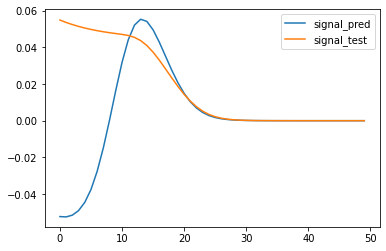

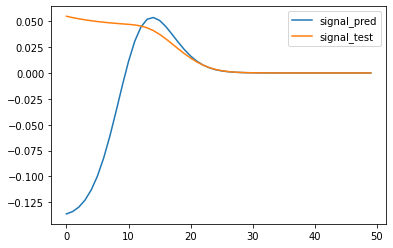

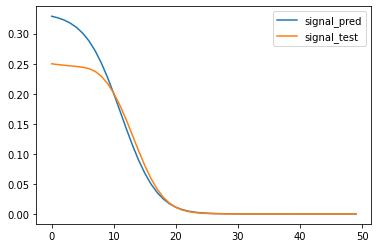

In [52]:
# Visualize 10 first pred and test signals
for i in range (10):
    plt.plot(signal_pred[i], label='signal_pred')
    plt.plot(signal_test[i], label='signal_test')
    plt.legend()
    plt.show()

In [53]:
# Inverse problem: by signal predict parameters

# Scale data
scaler = StandardScaler().fit(signal_data)
signal_data_scaled = scaler.transform(signal_data)

# Split data to train and test
signal_train, signal_test, params_train, params_test = train_test_split(signal_data_scaled, param_data, 
                                                    train_size=0.67, 
                                                    random_state=42)
regr = linear_model.LinearRegression()
# Fit model
regr.fit(signal_train, params_train)

In [59]:
params_pred = regr.predict(signal_test)
print("Mean squared error: %.25f" % mean_squared_error(params_test, params_pred))
print("Coefficient of determination: %.2f" % r2_score(params_test, params_pred))
## Coef is too low, linear regression is a bad choice

Mean squared error: 55183.2834106944865197874605656
Coefficient of determination: 0.32


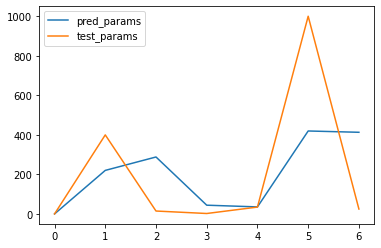

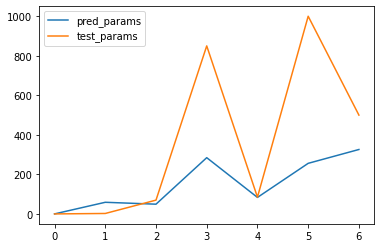

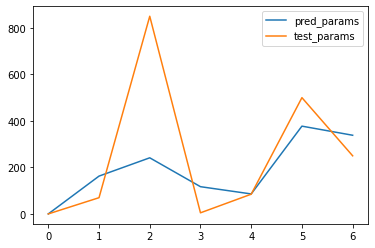

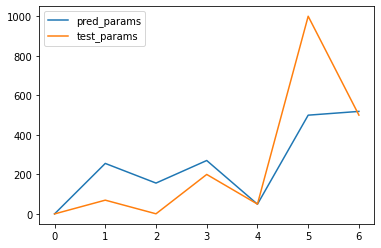

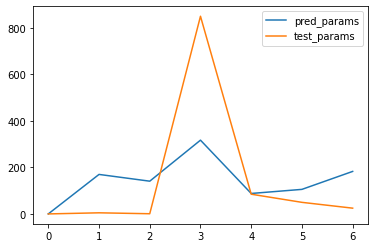

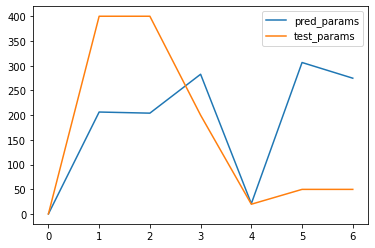

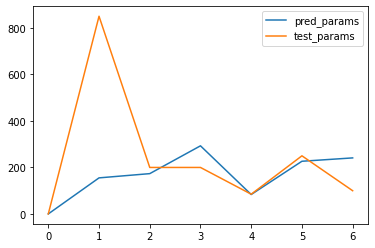

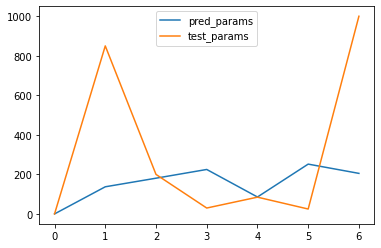

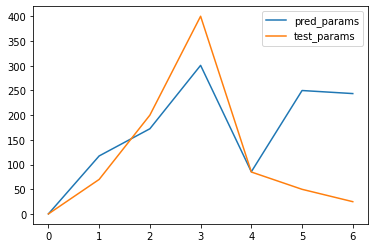

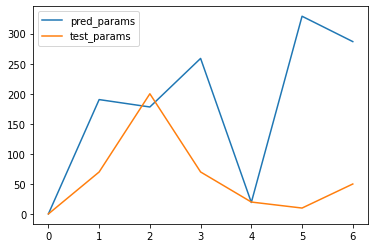

In [58]:
# Visualize 10 first pred and test params
for i in range (10):
    plt.plot(params_pred[i], label='pred_params')
    plt.plot(params_test[i], label='test_params')
    plt.legend()
    plt.show()